**Fichier principal : Construction, Nettoyage et Statisitques descriptives de nos données**

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
import requests
from fuzzywuzzy import fuzz             # pip install fuzzywuzzy python-Levenshtein
from unidecode import unidecode         # pip install unidecode
import matplotlib.pyplot as plt


On télécharge les bases de données brutes à partir des fichiers mis sur un drive publique : 

In [8]:
# Fonction pour télécharger le fichier depuis Google Drive
def download_file_from_google_drive(id, destination):
    URL = "https://drive.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [9]:
file_id = '1Xp9abybCL4lzRrAZrZaU69rCPFjGbBBJ'
destination = 'temp1.csv'

# Téléchargez le fichier depuis Google Drive
download_file_from_google_drive(file_id, destination)

coureur_tdf = pd.read_csv(destination)
coureur_tdf

,Unnamed: 0,Rank,Rider,Rider No.,Team,Times,Gap,B,P,Year,Distance (km),Number of stages,TotalSeconds,GapSeconds,ResultType
0,0,1,MAURICE GARIN,1,TDF 1903 ***,94h 33' 14'',-,NaN,NaN,1903,2428,6,340394,0,time
1,1,2,LUCIEN POTHIER,37,TDF 1903 ***,97h 32' 35'',+ 02h 59' 21'',NaN,NaN,1903,2428,6,351155,10761,time
2,2,3,FERNAND AUGEREAU,39,TDF 1903 ***,99h 02' 38'',+ 04h 29' 24'',NaN,NaN,1903,2428,6,356558,16164,time
3,3,4,RODOLPHE MULLER,33,TDF 1903 ***,99h 12' 44'',+ 04h 39' 30'',NaN,NaN,1903,2428,6,357164,16770,time
4,4,5,JEAN-BAPTISTE FISCHER,12,TDF 1903 ***,99h 41' 58'',+ 05h 08' 44'',NaN,NaN,1903,2428,6,358918,18524,time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9873,9873,146,ALEXANDER EDMONDSON,144,TEAM DSM - FIRMENICH,87h 50' 21'',+ 05h 44' 39'',NaN,NaN,2023,3404,21,316221,20679,time
9874,9874,147,FREDERIK FRISON,185,LOTTO DSTNY,88h 01' 02'',+ 05h 55' 20'',NaN,NaN,2023,3404,21,316862,21320,time
9875,9875,148,YEVGENIY FEDOROV,194,ASTANA QAZAQSTAN TEAM,88h 02' 19'',+ 05h 56' 37'',NaN,NaN,2023,3404,21,316939,21397,time
9876,9876,149,CEES BOL,192,ASTANA QAZAQSTAN TEAM,88h 03' 26'',+ 05h 57' 44'',NaN,NaN,2023,3404,21,317006,21464,time


**Étape 3 : Transformation des données** 

Nettoyage d'une première base de données (coureur_tdf) : 
    - Nom du coureur<br>
    - Classement (par année)<br>
    - Equipe<br>
    - Temps<br>
    - Année<br>
    - Distance<br>
    - ...

In [10]:
coureur_tdf.rename(columns={coureur_tdf.columns[2]: 'nom'}, inplace=True)
coureur_tdf['nom'] = coureur_tdf['nom'].str.title()
coureur_tdf['nom'] = coureur_tdf['nom'].str.title().str.strip()
coureur_tdf['nom'] = coureur_tdf['nom'].apply(unidecode)
coureur_tdf

,Unnamed: 0,Rank,nom,Rider No.,Team,Times,Gap,B,P,Year,Distance (km),Number of stages,TotalSeconds,GapSeconds,ResultType
0,0,1,Maurice Garin,1,TDF 1903 ***,94h 33' 14'',-,NaN,NaN,1903,2428,6,340394,0,time
1,1,2,Lucien Pothier,37,TDF 1903 ***,97h 32' 35'',+ 02h 59' 21'',NaN,NaN,1903,2428,6,351155,10761,time
2,2,3,Fernand Augereau,39,TDF 1903 ***,99h 02' 38'',+ 04h 29' 24'',NaN,NaN,1903,2428,6,356558,16164,time
3,3,4,Rodolphe Muller,33,TDF 1903 ***,99h 12' 44'',+ 04h 39' 30'',NaN,NaN,1903,2428,6,357164,16770,time
4,4,5,Jean-Baptiste Fischer,12,TDF 1903 ***,99h 41' 58'',+ 05h 08' 44'',NaN,NaN,1903,2428,6,358918,18524,time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9873,9873,146,Alexander Edmondson,144,TEAM DSM - FIRMENICH,87h 50' 21'',+ 05h 44' 39'',NaN,NaN,2023,3404,21,316221,20679,time
9874,9874,147,Frederik Frison,185,LOTTO DSTNY,88h 01' 02'',+ 05h 55' 20'',NaN,NaN,2023,3404,21,316862,21320,time
9875,9875,148,Yevgeniy Fedorov,194,ASTANA QAZAQSTAN TEAM,88h 02' 19'',+ 05h 56' 37'',NaN,NaN,2023,3404,21,316939,21397,time
9876,9876,149,Cees Bol,192,ASTANA QAZAQSTAN TEAM,88h 03' 26'',+ 05h 57' 44'',NaN,NaN,2023,3404,21,317006,21464,time


Téléchargement et Nettoyage d'une deuxième base de données (prix_coureur_tdf): 

In [11]:
# L'ID du fichier Google Drive https://drive.google.com/file/d/1RCUw5BPznYv5xWpzNkoarlmH57z-jS3W/view?usp=sharing
file_id = '1RCUw5BPznYv5xWpzNkoarlmH57z-jS3W'
destination = 'temp2.csv'

# Téléchargez le fichier depuis Google Drive
download_file_from_google_drive(file_id, destination)

# Charger le fichier CSV dans un DataFrame
prix_coureur_tdf = pd.read_csv(destination)

# Afficher les informations de base sur le DataFrame
print(prix_coureur_tdf.shape)

# Renommer les colonnes
prix_coureur_tdf.columns = ['nom', 'nbre_tdf', 'nbre_victoire_etape', 'nbre_jour_maillot_jaune']
prix_coureur_tdf['nom'] = prix_coureur_tdf['nom'].apply(unidecode)

# Afficher le DataFrame
print(prix_coureur_tdf)

(818, 4)
                          nom  nbre_tdf  nbre_victoire_etape  \
0    Djamolidine Abdoujaparov       8.0                    0   
1           Jean Adriaenssens       8.0                    0   
2                 Mario Aerts      10.0                    0   
3        Christophe Agnolutto       5.0                    1   
4           Joaquim Agostinho      13.0                    0   
..                        ...       ...                  ...   
813            Stefano Zanini       3.0                    1   
814             Italo Zilioli       1.0                    1   
815            Urs Zimmermann       3.0                    0   
816            Joop Zoetemelk      15.0                   10   
817           Haimar Zubeldia      15.0                    0   

     nbre_jour_maillot_jaune  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0  
..                       ...  
813  

Correction des erreurs dues au scrapping sur les gagnants des étapes et sur les maillots jaunes : 

On a en effet observé dans un premier temps des erreurs grâce aux statistiques descriptives. 
Nous nous sommes aidés de deux nouvelles bases de données (sur les gagnants des étapes et sur les maillots jaunes) pour corriger le manque de valeurs dû à des erreurs de scraping.

In [12]:
# Importation de la base de données gagnants_etapes 

# https://drive.google.com/file/d/1sApLsrFrpSYi0Nqoap1cnv5x4U3jjgK3/view?usp=sharing

file_id = '1sApLsrFrpSYi0Nqoap1cnv5x4U3jjgK3'
destination = 'temp3.csv'

# Téléchargez le fichier depuis Google Drive
download_file_from_google_drive(file_id, destination)

# Charger le fichier CSV dans un DataFrame

gagnants_etape = pd.read_csv(destination)
gagnants_etape['Winner'] = gagnants_etape['Winner'].apply(unidecode)
gagnants_etape

,Year,Stage,Winner
0,1947,1,Ferdi Kubler
1,1947,2,Rene Vietto
2,1947,3,Aldo Ronconi
3,1947,4,Jean Robic
4,1947,5,Ferdi Kubler
...,...,...,...
1638,2019,17,Matteo Trentin
1639,2019,18,Nairo Quintana
1640,2019,19,Pas de vainqueur
1641,2019,20,Vincenzo Nibali


In [13]:
# Extraction des noms de coureurs de la base de données prix_coureur_tdf
names_in_old_db = prix_coureur_tdf['nom']

# Extraction des noms de coureurs de la base de données gagnants_etape
names_in_new_db = gagnants_etape['Winner']

# Trouver l'intersection des ensembles de noms de coureurs
intersection = set(names_in_new_db) & set(names_in_old_db)

print(len(intersection))

531


In [14]:
# Créer un dictionnaire des comptes de victoires de la base de données des vainqueurs
victory_counts = gagnants_etape['Winner'].value_counts().to_dict()
print(victory_counts)
nombre_erreur_modifiee = 0

# Faire une copie pour éviter de modifier le DataFrame pendant l'itération
db_to_correct = prix_coureur_tdf.copy()

# Mettre à jour les victoires dans la base de données à corriger
for index, row in db_to_correct.iterrows():
    name = row['nom']
    correct_victories = victory_counts.get(name, 0)  # Obtient le nombre de victoires du nom ou 0 si non trouvé

    if row['nbre_victoire_etape'] != correct_victories:
        print(f"Modification: {name} de {row['nbre_victoire_etape']} à {correct_victories}")  # Imprime les changements
        db_to_correct.at[index, 'nbre_victoire_etape'] = correct_victories  # Mise à jour du nombre de victoires
        nombre_erreur_modifiee += 1

print(f"Nombre d'erreurs modifiées : {nombre_erreur_modifiee}")

# Enregistrez les modifications dans la base de données prix_coureur_tdf
prix_coureur_tdf.update(db_to_correct)



{'Eddy Merckx': 34, 'Mark Cavendish': 30, 'Bernard Hinault': 28, 'Andre Darrigade': 22, 'Lance Armstrong  (1)': 19, 'Jacques Anquetil': 16, 'Freddy Maertens': 15, 'Marcel Kittel': 14, 'Peter Sagan': 12, 'Mario Cipollini': 12, 'Miguel Indurain': 12, 'Erik Zabel': 12, 'Robbie McEwen': 11, 'Thor Hushovd': 11, 'Louison Bobet': 11, 'Andre Greipel': 11, 'Charly Gaul': 10, 'Gerrie Knetemann': 10, 'Joop Zoetemelk': 10, 'Walter Godefroot': 10, 'Jan Raas': 10, 'Gino Bartali': 9, 'Bernard Thevenet': 9, 'Tom Steels': 9, 'Lucien Van Impe': 9, 'Luis Ocana': 9, 'Laurent Fignon': 9, 'Fausto Coppi': 9, 'Jean-Paul Van Poppel': 9, 'Barry Hoban': 8, 'Roger Hassenforder': 8, 'Marco Pantani': 8, 'Ferdi Kubler': 8, 'Rudi Altig': 8, 'Ti-Raleigh': 8, 'Cyrille Guimard': 7, 'Nino Defilippis': 7, 'Raphael Geminiani': 7, 'Raymond Poulidor': 7, 'Rik Van Looy': 7, 'Fiorenzo Magni': 7, 'Jan Janssen': 7, 'Felice Gimondi': 7, 'Edouard Sels': 7, 'Richard Virenque': 7, 'Fabian Cancellara': 7, 'Federico Bahamontes': 7, 'C

On refait pareil pour la colonne nbre_jour_maillot_jaune car certains noms composés notamment ceux hollandais avait fait bugger le scrapping : 

In [15]:
# https://drive.google.com/file/d/1qdlOkGcP-VQysoqWmzjMOl-BBHYmgQhO/view?usp=sharing

file_id = '1qdlOkGcP-VQysoqWmzjMOl-BBHYmgQhO'
destination = 'temp.csv'

# Téléchargez le fichier depuis Google Drive
download_file_from_google_drive(file_id, destination)

maillot_jaune = pd.read_csv(destination)
maillot_jaune['Name'] = maillot_jaune['Name'].apply(unidecode)
maillot_jaune

,Name,Yellow Jerseys
0,Eddy Merckx,96
1,Bernard Hinault,79
2,Miguel Indurain,60
3,Christopher Froome,59
4,Jacques Anquetil,51
...,...,...
293,Fernando Gaviria,1
294,Alexander Kristoff,1
295,Yves Lampaert,1
296,Jai Hindley,1


In [16]:
db_to_correct = prix_coureur_tdf.copy()  # Faites une copie pour éviter de modifier la bdd pendant l'itération
correct_db = maillot_jaune

# Créer un dictionnaire des comptes de jours en maillot jaune de la base de données correcte
correct_days_yellow_jersey = correct_db.set_index('Name')['Yellow Jerseys'].to_dict()
print(correct_days_yellow_jersey)

nombre_erreur_modifiee = 0

# Mettre à jour les jours en maillot jaune dans la base de données à corriger
for index, row in db_to_correct.iterrows():
    name = row['nom']
    correct_days = correct_days_yellow_jersey.get(name)

    if correct_days is not None and row['nbre_jour_maillot_jaune'] != correct_days:
        db_to_correct.at[index, 'nbre_jour_maillot_jaune'] = correct_days
        nombre_erreur_modifiee += 1

# Affichez le nombre d'erreurs modifiées
print(f"Nombre d'erreurs modifiées : {nombre_erreur_modifiee}")


db_to_correct.to_csv('updated_' + destination, index=False)

# Enregistre les modifications dans un nouveau fichier 
db_to_correct.to_csv(destination, index=False)
prix_coureur_tdf = db_to_correct
prix_coureur_tdf

{'Eddy Merckx': 96, 'Bernard Hinault': 79, 'Miguel Indurain': 60, 'Christopher Froome': 59, 'Jacques Anquetil': 51, 'Antonin Magne': 38, 'Philippe Thys[n 1]': 37, 'Nicolas Frantz[n 2]': 37, 'Andre Leducq[n 2]': 35, 'Ottavio Bottecchia': 34, 'Louison Bobet': 34, 'Fabian Cancellara': 29, 'Jonas Vingegaard': 27, 'Sylvere Maes': 26, 'Rene Vietto': 26, 'Francois Faber': 25, 'Joop Zoetemelk': 22, 'Laurent Fignon': 22, 'Greg LeMond': 22, 'Romain Maes': 21, 'Tadej Pogacar': 21, 'Gino Bartali': 20, 'Thomas Voeckler': 20, 'Fausto Coppi': 19, 'Andre Darrigade': 19, 'Vincenzo Nibali': 19, 'Lucien Petit-Breton': 18, 'Felice Gimondi': 18, 'Jan Ullrich': 18, 'Julian Alaphilippe': 18, 'Odile Defraye': 17, 'Rudi Altig': 17, 'Roger Pingeon': 17, 'Luis Ocana': 17, 'Maurice De Waele': 16, 'Bernard Thevenet': 16, 'Dietrich Thurau': 15, 'Pedro Delgado[n 3]': 15, 'Geraint Thomas': 15, 'Leon Scieur': 14, 'Maurice Archambaud': 14, 'Gastone Nencini': 14, 'Steve Bauer': 14, 'Bjarne Riis': 14, 'Bradley Wiggins': 

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune
0,Djamolidine Abdoujaparov,8.0,0,0
1,Jean Adriaenssens,8.0,0,0
2,Mario Aerts,10.0,0,0
3,Christophe Agnolutto,5.0,1,0
4,Joaquim Agostinho,13.0,0,0
...,...,...,...,...
813,Stefano Zanini,3.0,1,0
814,Italo Zilioli,1.0,1,4
815,Urs Zimmermann,3.0,0,0
816,Joop Zoetemelk,15.0,10,22


On avait réussi à scraper les prix gagnés par certains coureurs cyclistes, et on va ensuite l'incorporer dans la grande base de donnée

In [17]:
# https://drive.google.com/file/d/1vGDnYaDpD22VCfhsL3Vmx26QGIrZBbYl/view?usp=sharing

file_id = '1vGDnYaDpD22VCfhsL3Vmx26QGIrZBbYl'
destination = 'temp.csv'

# Téléchargez le fichier depuis Google Drive
download_file_from_google_drive(file_id, destination)

df_maillot = pd.read_csv(destination)
df_maillot['Par points'] = df_maillot['Par points'].apply(lambda x: unidecode(str(x)))
df_maillot['Prix de la combativité'] = df_maillot['Prix de la combativité'].apply(lambda x: unidecode(str(x)))
df_maillot['Meilleur jeune'] = df_maillot['Meilleur jeune'].apply(lambda x: unidecode(str(x)))
df_maillot['Grand Prix de la montagne'] = df_maillot['Grand Prix de la montagne'].apply(lambda x: unidecode(str(x)))
df_maillot

,Grand Prix de la montagne,Par points,Meilleur jeune,Prix de la combativité,Année
0,nan,nan,nan,nan,1903
1,nan,nan,nan,nan,1904
2,nan,nan,nan,nan,1905
3,nan,nan,nan,nan,1906
4,nan,nan,nan,nan,1907
...,...,...,...,...,...
105,Romain Bardet,Peter Sagan,Egan Bernal,Julian Alaphilippe,2019
106,Tadej Pogacar,Sam Bennett,Tadej Pogacar,Marc Hirschi,2020
107,Tadej Pogacar,Mark Cavendish,Tadej Pogacar,Franck Bonnamour,2021
108,Jonas Vingegaard,Wout van Aert,Tadej Pogacar,Wout van Aert,2022


In [18]:
# Ajouter les nouvelles colonnes à coureur_tdf
for col in ['Grand Prix de la Montagne', 'Par Points', 'Meilleur Jeune', 'Prix de la Combativité']:
    coureur_tdf[col] = 0

# Remplir les nouvelles colonnes
for index, row in coureur_tdf.iterrows():
    # Obtenir l'année et le nom du coureur
    year = row['Year']
    name = row['nom']
    
    # Vérifier si le coureur a gagné un prix cette année
    # Remarque: on a binarisé les colonnes Grand Prix, par points, Meilleur jeune et prix de la combativité
    prix_row = df_maillot[df_maillot['Année'] == year]
    if not prix_row.empty:
        if name == prix_row['Grand Prix de la montagne'].values[0]:
            coureur_tdf.at[index, 'Grand Prix de la Montagne'] = 1
        if name == prix_row['Par points'].values[0]:
            coureur_tdf.at[index, 'Par Points'] = 1
        if name == prix_row['Meilleur jeune'].values[0]:
            coureur_tdf.at[index, 'Meilleur Jeune'] = 1
        if name == prix_row['Prix de la combativité'].values[0]:
            coureur_tdf.at[index, 'Prix de la Combativité'] = 1
coureur_tdf

,Unnamed: 0,Rank,nom,Rider No.,Team,Times,Gap,B,P,Year,Distance (km),Number of stages,TotalSeconds,GapSeconds,ResultType,Grand Prix de la Montagne,Par Points,Meilleur Jeune,Prix de la Combativité
0,0,1,Maurice Garin,1,TDF 1903 ***,94h 33' 14'',-,NaN,NaN,1903,2428,6,340394,0,time,0,0,0,0
1,1,2,Lucien Pothier,37,TDF 1903 ***,97h 32' 35'',+ 02h 59' 21'',NaN,NaN,1903,2428,6,351155,10761,time,0,0,0,0
2,2,3,Fernand Augereau,39,TDF 1903 ***,99h 02' 38'',+ 04h 29' 24'',NaN,NaN,1903,2428,6,356558,16164,time,0,0,0,0
3,3,4,Rodolphe Muller,33,TDF 1903 ***,99h 12' 44'',+ 04h 39' 30'',NaN,NaN,1903,2428,6,357164,16770,time,0,0,0,0
4,4,5,Jean-Baptiste Fischer,12,TDF 1903 ***,99h 41' 58'',+ 05h 08' 44'',NaN,NaN,1903,2428,6,358918,18524,time,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9873,9873,146,Alexander Edmondson,144,TEAM DSM - FIRMENICH,87h 50' 21'',+ 05h 44' 39'',NaN,NaN,2023,3404,21,316221,20679,time,0,0,0,0
9874,9874,147,Frederik Frison,185,LOTTO DSTNY,88h 01' 02'',+ 05h 55' 20'',NaN,NaN,2023,3404,21,316862,21320,time,0,0,0,0
9875,9875,148,Yevgeniy Fedorov,194,ASTANA QAZAQSTAN TEAM,88h 02' 19'',+ 05h 56' 37'',NaN,NaN,2023,3404,21,316939,21397,time,0,0,0,0
9876,9876,149,Cees Bol,192,ASTANA QAZAQSTAN TEAM,88h 03' 26'',+ 05h 57' 44'',NaN,NaN,2023,3404,21,317006,21464,time,0,0,0,0


Fusion avec la première base de données et nettoyage du résultat : 

In [19]:
# Compter les occurrences dans la deuxième base de données
comptage = coureur_tdf.groupby('nom').size().reset_index(name='comptage_unique')

# Vérifier si 'comptage_unique' existe déjà dans prix_coureur_tdf, si oui, le supprimer
if 'comptage_unique' in prix_coureur_tdf.columns:
    prix_coureur_tdf.drop('comptage_unique', axis=1, inplace=True)

# Fusionner avec la première base de données
prix_coureur_tdf = pd.merge(prix_coureur_tdf, comptage, on='nom', how='left')

# Mettre à jour la colonne 'nbre_tdf' là où elle vaut 0
prix_coureur_tdf.loc[prix_coureur_tdf['nbre_tdf'] == 0, 'nbre_tdf'] = prix_coureur_tdf['comptage_unique']

# Supprimer la colonne 'comptage_unique' car elle n'est plus nécessaire
prix_coureur_tdf.drop('comptage_unique', axis=1, inplace=True)
prix_coureur_tdf = prix_coureur_tdf.dropna()
prix_coureur_tdf

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune
0,Djamolidine Abdoujaparov,8.0,0,0
1,Jean Adriaenssens,8.0,0,0
2,Mario Aerts,10.0,0,0
3,Christophe Agnolutto,5.0,1,0
4,Joaquim Agostinho,13.0,0,0
...,...,...,...,...
813,Stefano Zanini,3.0,1,0
814,Italo Zilioli,1.0,1,4
815,Urs Zimmermann,3.0,0,0
816,Joop Zoetemelk,15.0,10,22


Fusion des DataFrames pour obtenir une base complète finale (merged_df) et nettoyage : 

In [20]:
# Fusion des DataFrames sur la colonne 'Stage_Key'
merged_df = pd.merge(prix_coureur_tdf, coureur_tdf, on='nom', how='inner')
merged_df = merged_df.dropna(axis=1, how='all')
# Suppression des colonnes inutiles
merged_df = merged_df.drop(['B', 'P', 'Unnamed: 0', 'Rider No.','Times','GapSeconds','Gap'], axis=1)

# Affichage des premières lignes du DataFrame fusionné pour vérification
merged_df

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune,Rank,Team,Year,Distance (km),Number of stages,TotalSeconds,ResultType,Grand Prix de la Montagne,Par Points,Meilleur Jeune,Prix de la Combativité
0,Djamolidine Abdoujaparov,8.0,0,0,145,ALFA LUM,1990,3504,22,335768,time,0,0,0,0
1,Djamolidine Abdoujaparov,8.0,0,0,85,CARRERA JEANS,1991,3914,23,370225,time,0,1,0,0
2,Djamolidine Abdoujaparov,8.0,0,0,76,LAMPRE-POLTI,1993,3714,21,352842,time,0,1,0,0
3,Djamolidine Abdoujaparov,8.0,0,0,57,TEAM POLTI,1994,3978,22,379812,time,0,1,0,0
4,Djamolidine Abdoujaparov,8.0,0,0,56,NOVELL,1995,3635,21,341634,time,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3452,Haimar Zubeldia,15.0,0,0,36,RADIOSHACK LEOPARD,2013,3404,21,307262,time,0,0,0,0
3453,Haimar Zubeldia,15.0,0,0,8,TREK FACTORY RACING,2014,3659,21,325023,time,0,0,0,0
3454,Haimar Zubeldia,15.0,0,0,62,TREK FACTORY RACING,2015,3354,21,314584,time,0,0,0,0
3455,Haimar Zubeldia,15.0,0,0,24,TREK - SEGAFREDO,2016,3525,21,323874,time,0,0,0,0


Création d'une colonne classement d'équipes : 

In [21]:
#Étape 1 : Grouper par équipe et année, puis obtenir les trois plus faibles temps

temps_par_equipe = merged_df.groupby(['Year', 'Team'])['TotalSeconds'].nsmallest(3).groupby(level=[0, 1]).sum()

# Étape 2 : Convertir la série groupée en DataFrame et réinitialiser l'index
temps_par_equipe = temps_par_equipe.reset_index()

# Étape 3 : Trier les équipes pour chaque année par leur temps total et obtenir le classement par équipe
temps_par_equipe['classement_equipe'] = temps_par_equipe.groupby('Year')['TotalSeconds'].rank(method='min')

# Étape 4 : Fusionner le classement par équipe avec le DataFrame original
df = pd.merge(merged_df, temps_par_equipe, on=['Year', 'Team'], how='left')
df_trie = df.sort_values(by='Year', ascending=True)
df_trie

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune,Rank,Team,Year,Distance (km),Number of stages,TotalSeconds_x,ResultType,Grand Prix de la Montagne,Par Points,Meilleur Jeune,Prix de la Combativité,TotalSeconds_y,classement_equipe
1830,Ludo Loos,3.0,1,0,20,TDF 1905 ***,1905,2994,11,0,NaN,0,0,0,0,0,1.0
2581,Pascal Richard,6.0,2,0,44,TOURISTES ROUTIERS,1924,5425,15,913722,time,0,0,0,0,913722,1.0
3228,Rene Vietto,3.0,2,26,5,FRANCE,1934,4470,24,533580,time,1,0,0,0,533580,1.0
3229,Rene Vietto,3.0,2,26,8,FRANCE,1935,4338,27,514383,time,0,0,0,0,514383,1.0
434,Albert Bourlon,2.0,1,0,35,BLEUETS,1938,4694,29,542832,time,0,0,0,0,542832,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904,Rafal Majka,8.0,3,0,14,UAE TEAM EMIRATES,2023,3404,21,298911,time,0,0,0,0,891100,10.0
2414,Thomas Pidcock,2.0,0,0,13,INEOS GRENADIERS,2023,3404,21,298414,time,0,0,0,0,900863,12.0
2022,Jordi Meeus,1.0,0,0,139,BORA - HANSGROHE,2023,3404,21,315573,time,0,0,0,0,907163,14.0
2109,Matej Mohoric,5.0,0,0,72,BAHRAIN VICTORIOUS,2023,3404,21,309407,time,0,0,0,0,309407,3.0


Pour le modèle de prédiction, on va créer une fonction qui prend en entrée un rang et qui redonne un nombre entre 0 et 1 avec 1 étant le moins bon rang, pour faciliter la prédiction du modèle.

In [22]:
# Fonction pour normaliser le classement des joueurs
def normalize_ranking(row, max_rank):
    return (max_rank - row) / (max_rank - 1)

# Appliquer la fonction à la colonne de classement individuel
max_rank = df_trie['Rank'].max()  # On cherche le rank le plus bas (nombre le plus grand)
df_trie['normalized_ranking'] = df_trie['Rank'].apply(lambda x: normalize_ranking(x, max_rank))
# On supprime ensuite la colonne Rank
df_trie = df_trie.drop(['TotalSeconds_y','Rank'], axis=1)
df_trie

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune,Team,Year,Distance (km),Number of stages,TotalSeconds_x,ResultType,Grand Prix de la Montagne,Par Points,Meilleur Jeune,Prix de la Combativité,classement_equipe,normalized_ranking
1830,Ludo Loos,3.0,1,0,TDF 1905 ***,1905,2994,11,0,NaN,0,0,0,0,1.0,0.890173
2581,Pascal Richard,6.0,2,0,TOURISTES ROUTIERS,1924,5425,15,913722,time,0,0,0,0,1.0,0.751445
3228,Rene Vietto,3.0,2,26,FRANCE,1934,4470,24,533580,time,1,0,0,0,1.0,0.976879
3229,Rene Vietto,3.0,2,26,FRANCE,1935,4338,27,514383,time,0,0,0,0,1.0,0.959538
434,Albert Bourlon,2.0,1,0,BLEUETS,1938,4694,29,542832,time,0,0,0,0,2.0,0.803468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904,Rafal Majka,8.0,3,0,UAE TEAM EMIRATES,2023,3404,21,298911,time,0,0,0,0,10.0,0.924855
2414,Thomas Pidcock,2.0,0,0,INEOS GRENADIERS,2023,3404,21,298414,time,0,0,0,0,12.0,0.930636
2022,Jordi Meeus,1.0,0,0,BORA - HANSGROHE,2023,3404,21,315573,time,0,0,0,0,14.0,0.202312
2109,Matej Mohoric,5.0,0,0,BAHRAIN VICTORIOUS,2023,3404,21,309407,time,0,0,0,0,3.0,0.589595


Sauvegarde de la base de donnée finale : 

In [23]:
df_trie.to_csv('merged_database.csv', index=False)

In [24]:
print(df_trie.columns)

Index(['nom', 'nbre_tdf', 'nbre_victoire_etape', 'nbre_jour_maillot_jaune',
       'Team', 'Year', 'Distance (km)', 'Number of stages', 'TotalSeconds_x',
       'ResultType', 'Grand Prix de la Montagne', 'Par Points',
       'Meilleur Jeune', 'Prix de la Combativité', 'classement_equipe',
       'normalized_ranking'],
      dtype='object')


**Étape 4 : Statistiques Descriptives**
On fait des Statistiques Descriptives pour comprendre nos données et vérifier que le modèle est applicable :

Aperçu des premières lignes du DataFrame :
                 nom  nbre_tdf  nbre_victoire_etape  nbre_jour_maillot_jaune  \
1830       Ludo Loos       3.0                    1                        0   
2581  Pascal Richard       6.0                    2                        0   
3228     Rene Vietto       3.0                    2                       26   
3229     Rene Vietto       3.0                    2                       26   
434   Albert Bourlon       2.0                    1                        0   

                    Team  Year  Distance (km)  Number of stages  \
1830        TDF 1905 ***  1905           2994                11   
2581  TOURISTES ROUTIERS  1924           5425                15   
3228              FRANCE  1934           4470                24   
3229              FRANCE  1935           4338                27   
434              BLEUETS  1938           4694                29   

      TotalSeconds_x ResultType  Grand Prix de la Montagne  Par Points  \

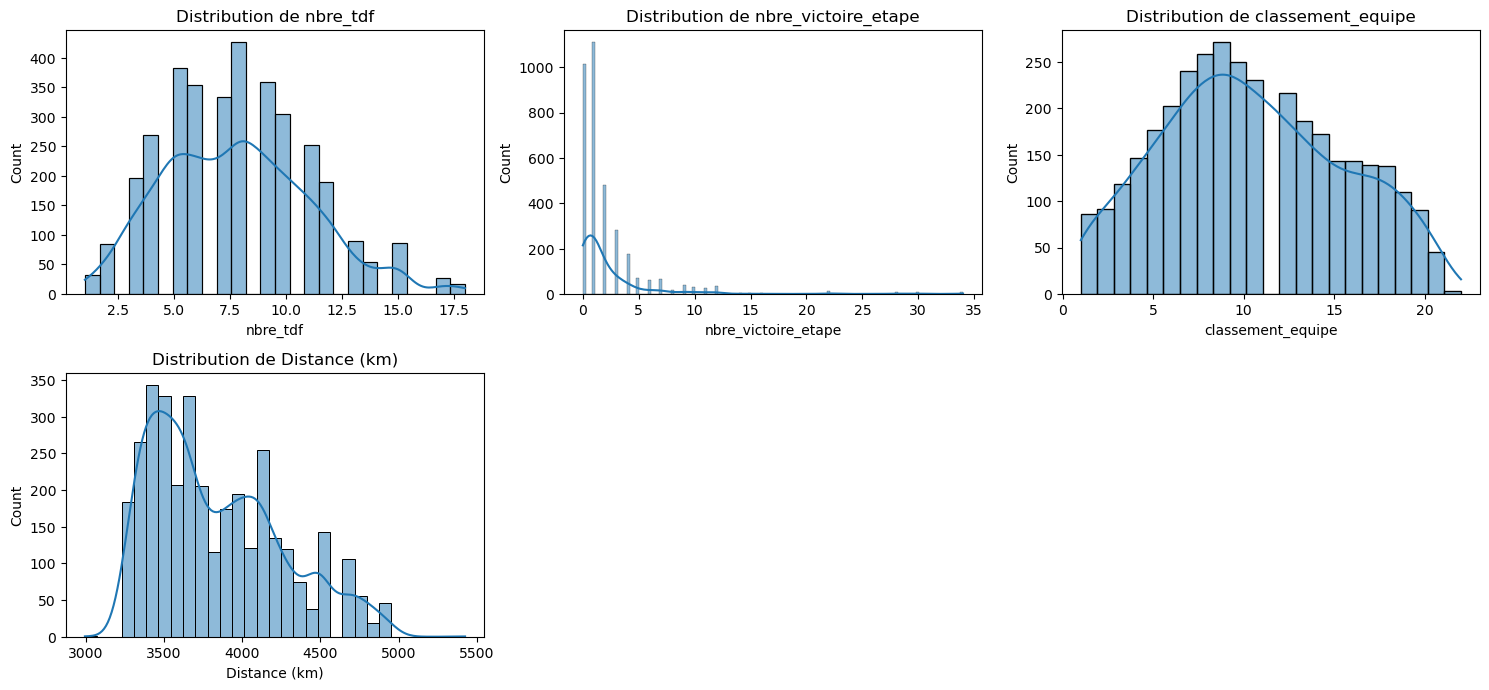

In [25]:
# Afficher les premières lignes du DataFrame
print("Aperçu des premières lignes du DataFrame :")
print(df_trie.head())

# Résumé statistique des données numériques
numeric_summary = df_trie.describe()
print("\nRésumé statistique des données numériques :")
print(numeric_summary)

# Distribution des variables
plt.figure(figsize=(15, 10))

# Histogramme pour les variables numériques

selected_cols = ['nbre_tdf','nbre_victoire_etape', 'classement_equipe', 'Distance (km)'] 

for i, col in enumerate(selected_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(df_trie[col], kde=True)
    plt.title(f'Distribution de {col}')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Classement général')

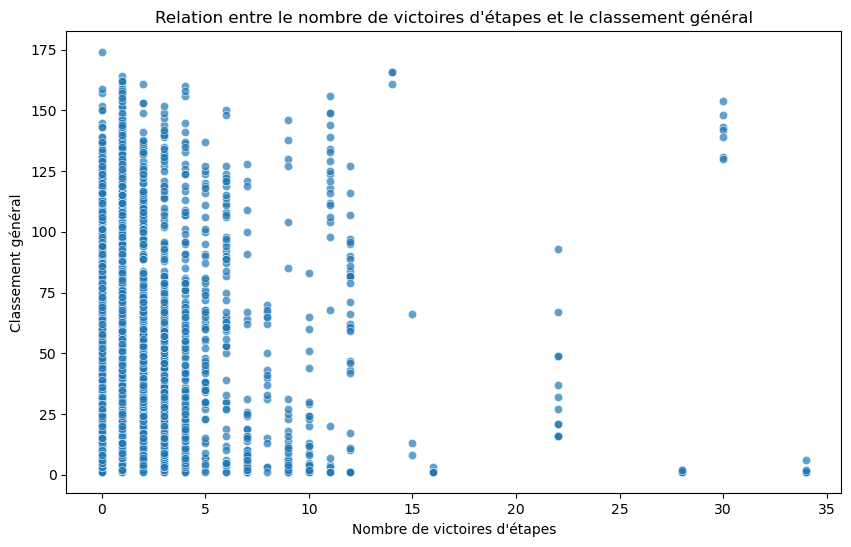

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='nbre_victoire_etape', y='Rank', data=merged_df, alpha=0.7)

# Ajouter des titres et des étiquettes
plt.title('Relation entre le nombre de victoires d\'étapes et le classement général')
plt.xlabel('Nombre de victoires d\'étapes')
plt.ylabel('Classement général')

On veut regarder l'évolution dans le temps des équipes. Pour cela on fait une heatmap sur la bdd grouped_by_team.
On se cantonne aux années > 2015 pour obtenir une heatmap lisible mais en realité on pourrait commencer beaucoup plus tôt.

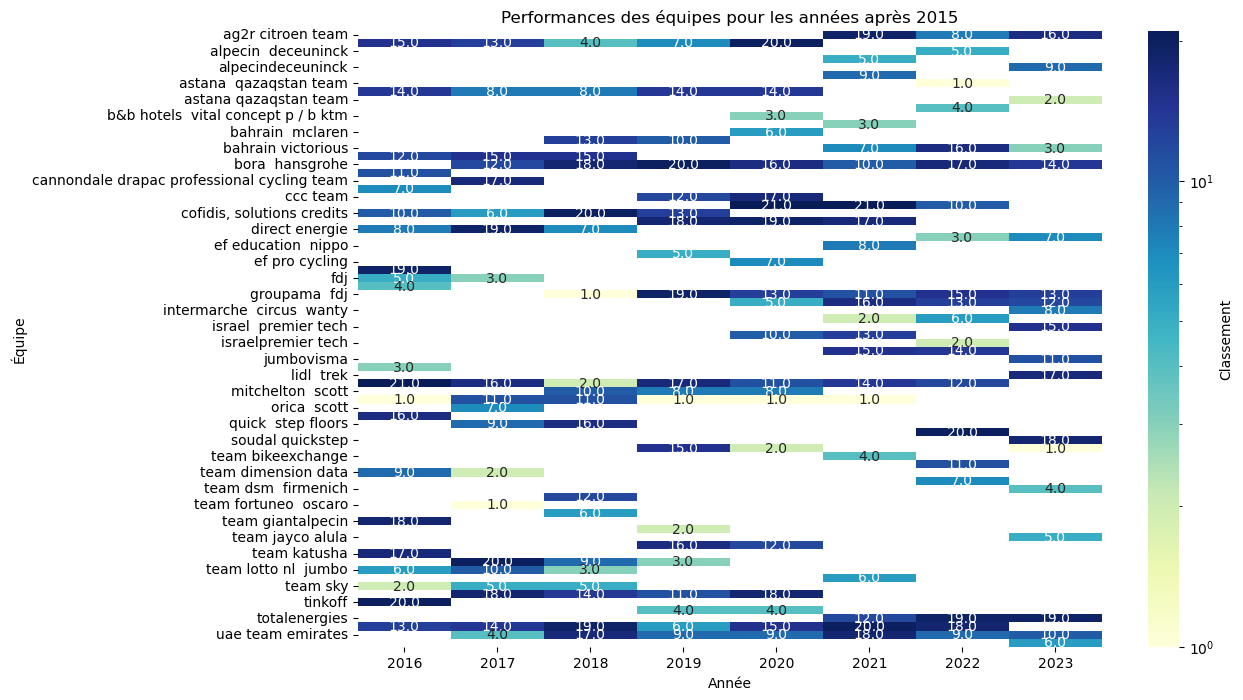

In [28]:
from matplotlib.colors import LogNorm
# On regroupe les données par équipe et année :
grouped_by_team = df_trie.groupby(['Team', 'Year'])

# Filtrer pour obtenir seulement les années après 2015
df_after_2015 = grouped_by_team.filter(lambda x: x['Year'].max() > 2015).copy()

# Fonction pour normaliser les noms d'équipe car certaines équipes ont plusieurs manières d'être écrite : 
def normalize_team_name(name):
    normalized_name = unidecode(name.lower())  # Convertit en minuscules et supprime les accents
    normalized_name = normalized_name.replace('-', '')  # Supprime les tirets
    return normalized_name

# Appliquer la normalisation aux noms d'équipe
df_after_2015['Normalized_Team'] = df_after_2015['Team'].apply(normalize_team_name)

# Dictionnaire pour stocker les correspondances trouvées
team_matches = {}

# Itération sur les équipes uniques
for team in df_after_2015['Normalized_Team'].unique():
    # Trouver la meilleure correspondance pour chaque équipe
    match, score = max(((t, fuzz.ratio(team, t)) for t in df_after_2015['Normalized_Team'].unique()), key=lambda x: x[1])
    
    # Ajouter la correspondance au dictionnaire
    if score >= 80:
        team_matches[team] = match

# Mettre à jour le DataFrame avec les correspondances trouvées
df_after_2015['Normalized_Team'] = df_after_2015['Normalized_Team'].map(team_matches)

# Agréger les classements après la fusion
df_aggregated = df_after_2015.groupby(['Year', 'Normalized_Team']).agg({'classement_equipe': 'mean'}).reset_index()

# Heatmap des performances par équipe pour les années après 2010 (en utilisant 'Rank')
plt.figure(figsize=(12, 8))
heatmap_data = df_aggregated.pivot(index='Normalized_Team', columns='Year', values='classement_equipe')

# Utilisation d'une colormap différente ("YlGnBu"), ajustement des limites de couleur et échelle logarithmique
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt='.1f', cbar_kws={'label': 'Classement'}, vmin=0, vmax=50, norm=LogNorm())

plt.title('Performances des équipes pour les années après 2015')
plt.xlabel('Année')
plt.ylabel('Équipe')
plt.show()

In [29]:
# Sélectionner uniquement les colonnes numériques
colonnes_numeriques = merged_df.select_dtypes(include='number')

# Filtrer les données où 'Year' est supérieur à 1946 (on peut décider d'autres dâtes)
colonnes_numeriques = colonnes_numeriques[colonnes_numeriques['Year'] > 1946]

# Grouper par année
grouped_by_year = colonnes_numeriques.groupby('Year')

# Calculer la moyenne par colonne pour chaque groupe
mean_by_column = grouped_by_year.mean()


# On observe pour une année en particulier pour mieux comprendre les données. 
groupe_1948 = grouped_by_year.get_group(1948)
groupe_1948_classé = groupe_1948.sort_values(by='Rank', ascending=True)
print(groupe_1948_classé)

      nbre_tdf  nbre_victoire_etape  nbre_jour_maillot_jaune  Rank  Year  \
237        6.0                    9                       20     1  1948   
367       10.0                   11                       34     4  1948   
2970       8.0                    4                        0     6  1948   
1720       3.0                    2                        3     7  1948   
534        3.0                    2                        0     8  1948   
1489       8.0                    3                        0    10  1948   
2260       8.0                    3                        0    11  1948   
2454       3.0                    0                        0    13  1948   
2601      10.0                    6                        2    16  1948   
3232       3.0                    2                       26    17  1948   
1182       8.0                    1                        7    24  1948   
718        6.0                    3                        0    29  1948   

      Dista

Base de données par coureur depuis 2010 pour voir les performances individuelles : 

In [30]:
# Convertir la colonne 'Year' en type datetime avec seulement l'année
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

# Filtrer les données pour les années à partir de 2010
df_since_2010 = df[df['Year'].dt.year >= 2010]

# Groupement par coureur
grouped_by_rider_since_2010 = df_since_2010.groupby('nom')

# Calcul des statistiques descriptives
average_rank_since_2010 = grouped_by_rider_since_2010['Rank'].mean()
participation_count_since_2010 = grouped_by_rider_since_2010['Year'].count()
variance_performance_since_2010 = grouped_by_rider_since_2010['Rank'].var()
best_rank_since_2010 = grouped_by_rider_since_2010['Rank'].min()

# Création d'un nouveau DataFrame avec les données agrégées
aggregated_data_since_2010 = pd.DataFrame({
    'Moyenne_Classement_indiv': average_rank_since_2010,
    'Nombre_Participations': participation_count_since_2010,
    'Variance_Classement_indiv': variance_performance_since_2010,
    'Meilleur_Classement_indiv' : best_rank_since_2010
})

# Réinitialisation de l'index pour faire de 'nom' une colonne plutôt qu'un index
aggregated_data_since_2010.reset_index(inplace=True)

# Affichage du nouveau DataFrame
print(aggregated_data_since_2010)

                      nom  Moyenne_Classement_indiv  Nombre_Participations  \
0              Adam Yates                 19.142857                      7   
1        Alberto Contador                  6.000000                      3   
2      Alejandro Valverde                 11.111111                      9   
3       Alessandro Ballan                 87.000000                      1   
4    Alessandro De Marchi                 80.500000                      4   
..                    ...                       ...                    ...   
181        Warren Barguil                 15.714286                      7   
182         Wout Van Aert                 20.333333                      3   
183     Yaroslav Popovych                 81.000000                      2   
184         Yves Lampaert                109.250000                      4   
185         Zdenek Stybar                102.500000                      2   

     Variance_Classement_indiv  Meilleur_Classement_indiv  
0  

On peut afficher des statistiques élémentaires sur les coureurs depuis 2010 :

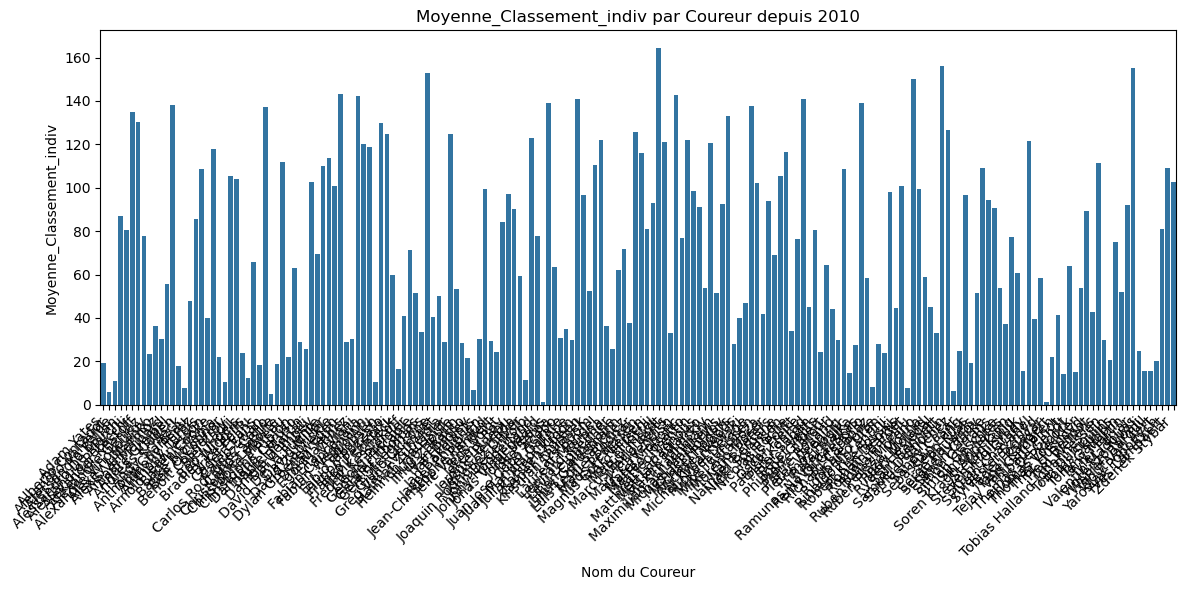

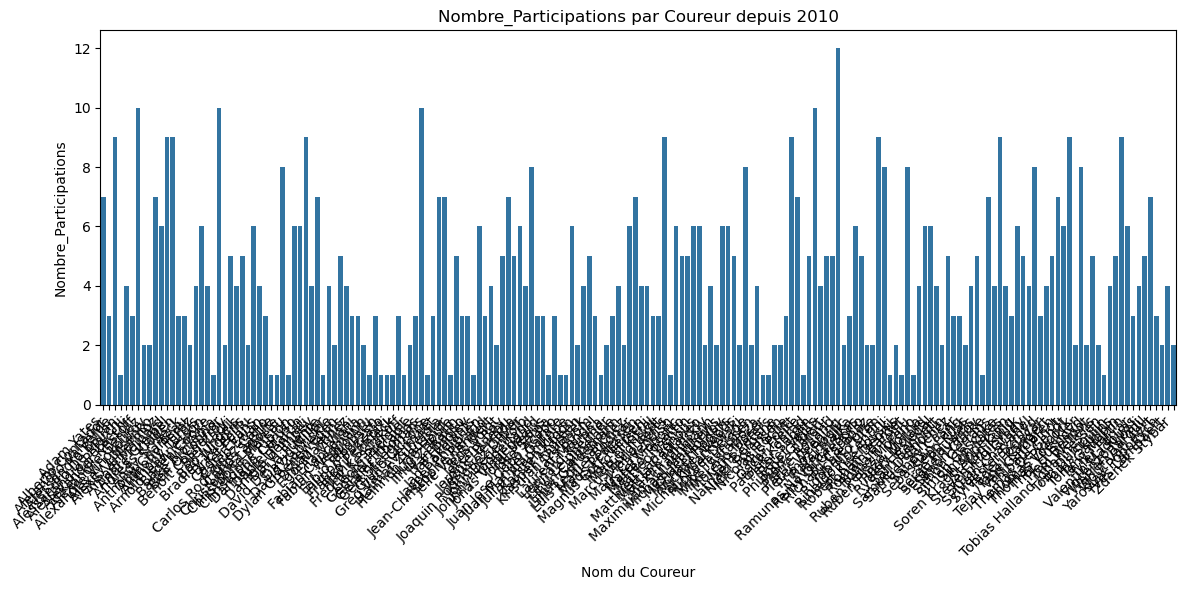

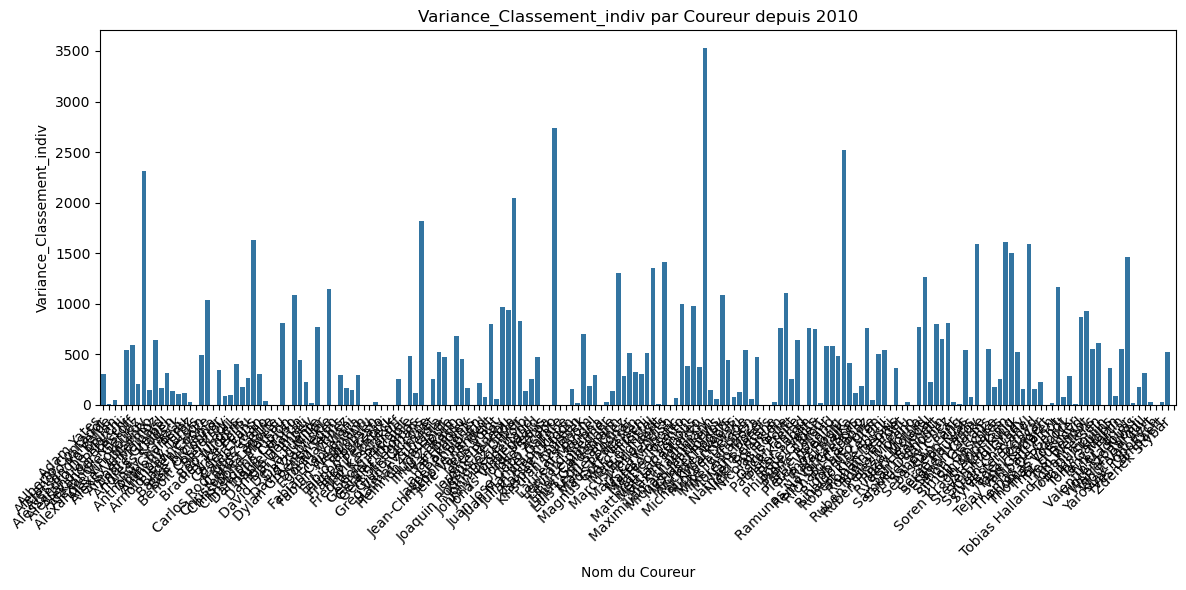

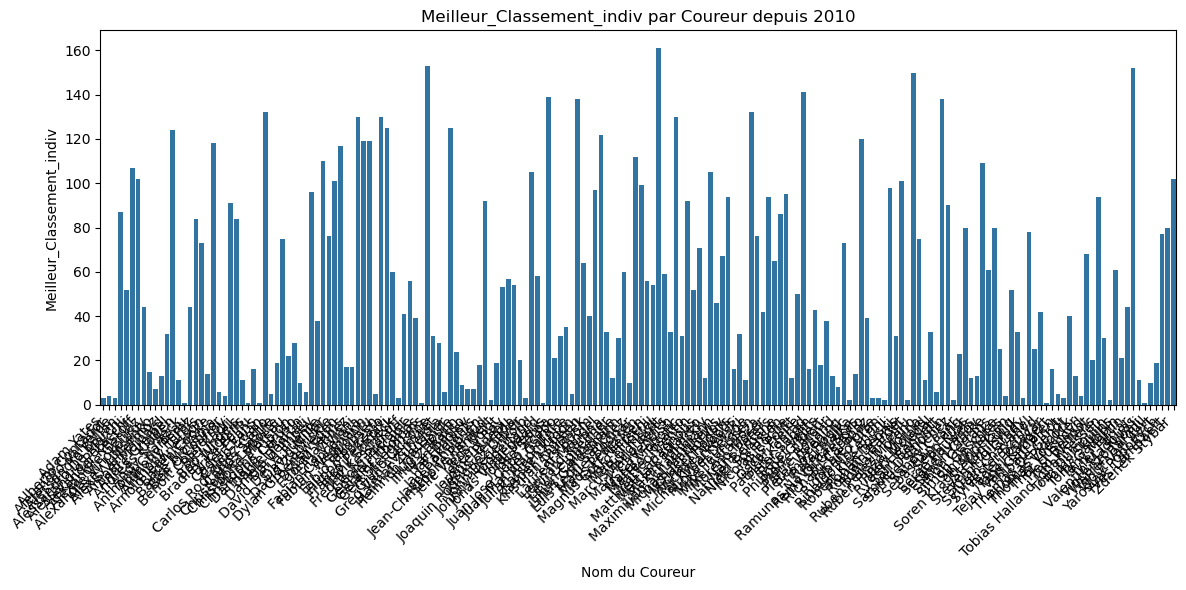

In [31]:
# Liste des statistiques à visualiser
statistiques = ['Moyenne_Classement_indiv', 'Nombre_Participations', 'Variance_Classement_indiv','Meilleur_Classement_indiv']

# Boucle pour créer un graphique pour chaque statistique
for stat in statistiques:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='nom', y=stat, data=aggregated_data_since_2010)
    plt.title(f'{stat} par Coureur depuis 2010')
    plt.xlabel('Nom du Coureur')
    plt.ylabel(stat)
    plt.xticks(rotation=45, ha='right')  # Rotation des noms de coureurs pour une meilleure lisibilité
    plt.tight_layout()

# Afficher les graphiques
plt.show()

Base de données par coureur depuis 1980 pour voir les performances individuelles : 

In [33]:
# Filtrer les données pour les années à partir de 1980
df_since_1980 = df[df['Year'].dt.year >= 1980]

# Groupement par coureur
grouped_by_rider_since_1980 = df_since_1980.groupby('nom')

# Calcul des statistiques descriptives
average_rank_since_1980 = grouped_by_rider_since_1980['Rank'].mean()
participation_count_since_1980 = grouped_by_rider_since_1980['Year'].count()
variance_performance_since_1980 = grouped_by_rider_since_1980['Rank'].var()
best_rank_since_1980 = grouped_by_rider_since_1980['Rank'].min()

# Création d'un nouveau DataFrame avec les données agrégées
aggregated_data_since_1980 = pd.DataFrame({
    'Moyenne_Classement_indiv': average_rank_since_1980,
    'Nombre_Participations': participation_count_since_1980,
    'Variance_Classement_indiv': variance_performance_since_1980,
    'Meilleur_Classement_indiv': best_rank_since_1980
})

# Réinitialisation de l'index pour faire de 'nom' une colonne plutôt qu'un index
aggregated_data_since_1980.reset_index(inplace=True)
aggregated_data_since_1980

,nom,Moyenne_Classement_indiv,Nombre_Participations,Variance_Classement_indiv,Meilleur_Classement_indiv
0,Abraham Olano,26.833333,6,790.566667,4
1,Acacio Da Silva,81.833333,6,308.966667,61
2,Adam Yates,19.142857,7,303.809524,3
3,Aitor Garmendia,74.200000,5,813.700000,35
4,Alain Meslet,41.000000,1,NaN,41
...,...,...,...,...,...
470,Yves Hezard,71.000000,1,NaN,71
471,Yves Lampaert,109.250000,4,520.916667,80
472,Yvon Bertin,104.500000,2,760.500000,85
473,Zdenek Stybar,102.500000,2,0.500000,102


On peut afficher l'effet du nombre de participation sur le meilleur classement pour avoir une idée du lien entre les deux : 

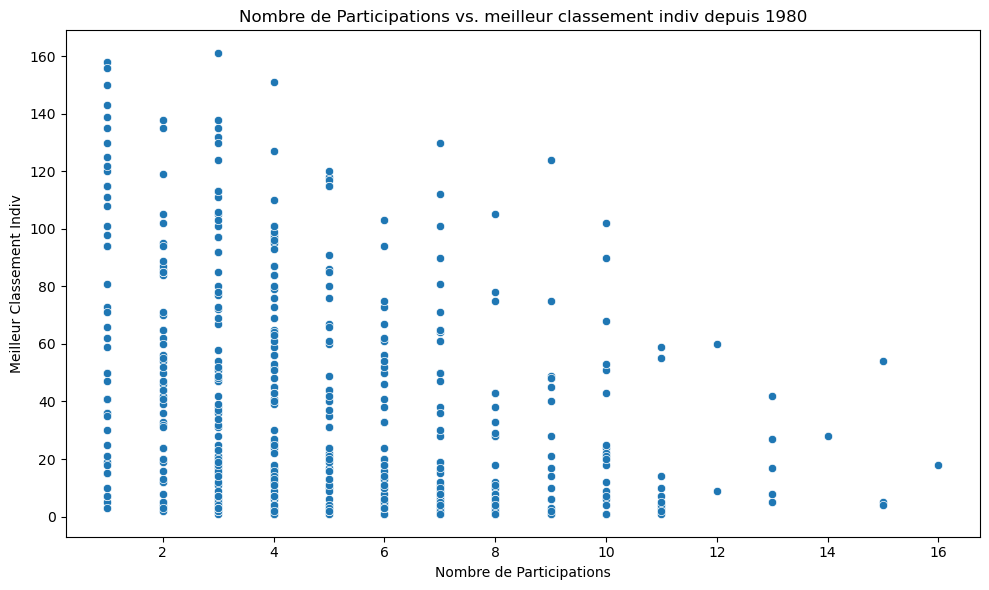

In [34]:
# Tracer un nuage de points pour le nombre de participations vs. le meilleur classement 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Nombre_Participations', y='Meilleur_Classement_indiv', data=aggregated_data_since_1980)
plt.title('Nombre de Participations vs. meilleur classement indiv depuis 1980')
plt.xlabel('Nombre de Participations')
plt.ylabel('Meilleur Classement Indiv')
plt.tight_layout()

# Afficher le nuage de points
plt.show()

Plus on participe à la course meilleur sera notre classement en moyenne. Cela parait logique mais il est toujours bon de le vérifier.

On va maintenant créer une Heatmap des colinéarités pour vérifier qu'il n'y aura pas d'erreur dans nos prédictions : 
Il ne semble pas y avoir de problèmes.

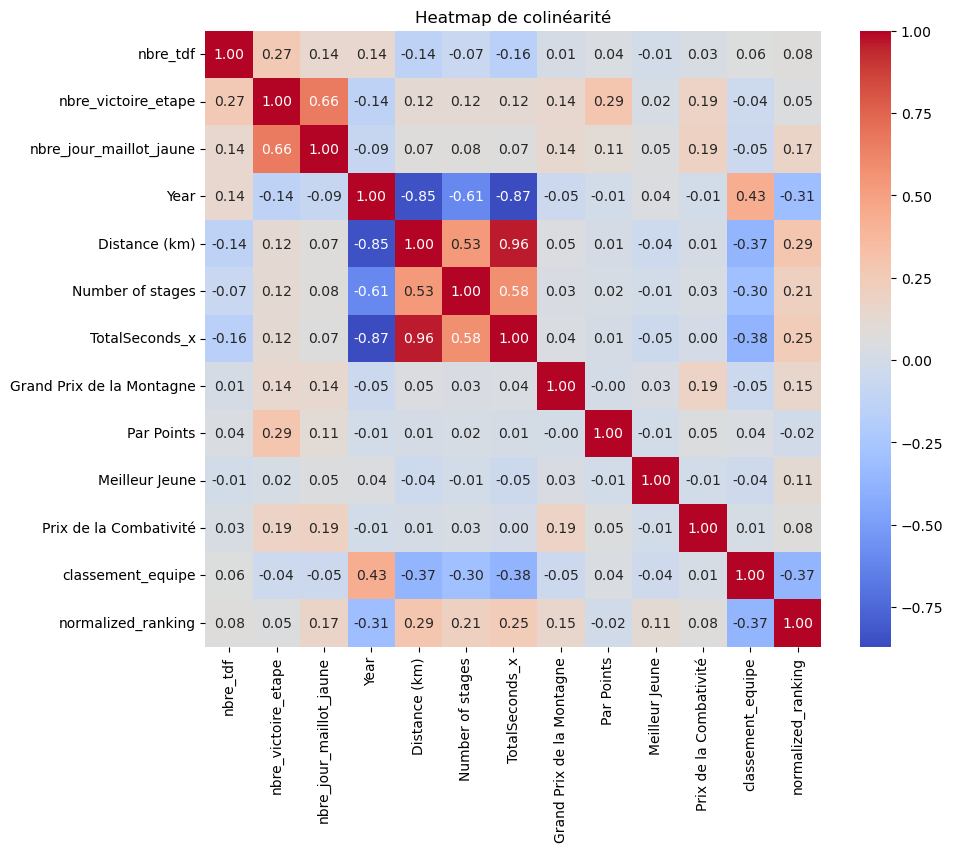

In [35]:
numeric_df = df_trie.select_dtypes(include='number')
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

plt.title("Heatmap de colinéarité")
plt.show()

**Étape 5 : Modèles prédictifs**
On test différents modèles prédictifs pour le rang des différents coureurs cyclistes

In [36]:
def train_and_test(X: pd.DataFrame, y):
    """
    Train and test on provided inputs.
    """
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initializing models
    models = {
        'Linear Regression': LinearRegression(),
        'Support Vector Regression': SVR(),
        'Decision Tree Regressor': DecisionTreeRegressor(),
        'Random Forest Regressor': RandomForestRegressor(),
        'Gradient Boosting Regressor': GradientBoostingRegressor()
    }

    # Training and evaluating models
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # Training and evaluating models with additional metrics
    scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        scores[name] = {'MSE': mse, 'MAE': mae, 'R²': r2}


    # Printing scores for each model
    for name, metrics in scores.items():
        print(f"{name} - MSE: {metrics['MSE']}, MAE: {metrics['MAE']}, R²: {metrics['R²']}")
    return scores

In [37]:
features_col_names = ['nbre_tdf',	'nbre_victoire_etape',	'nbre_jour_maillot_jaune',	'Distance (km)',	'Number of stages',	'TotalSeconds_x',	'Grand Prix de la Montagne',	'Par Points',	'Meilleur Jeune',	'Prix de la Combativité']

# Séparez le DataFrame en une matrice de features (X) et une colonne de labels (y)
X = df_trie[features_col_names]  # Matrice de features (X)
y = df_trie['normalized_ranking']         # Colonne de labels (y)~

train_and_test(X, y)

Linear Regression - MSE: 0.04088560146242961, MAE: 0.16312922148057044, R²: 0.19813812975195355
Support Vector Regression - MSE: 0.04826516302142659, MAE: 0.17515034173872004, R²: 0.05340774003895199
Decision Tree Regressor - MSE: 0.006020172597304951, MAE: 0.037630726051655586, R²: 0.8819303939425495
Random Forest Regressor - MSE: 0.002993227763317309, MAE: 0.037930853018811175, R²: 0.9412958321139648
Gradient Boosting Regressor - MSE: 0.02240559881652127, MAE: 0.11666713468507914, R²: 0.5605740229221633


{'Linear Regression': {'MSE': 0.04088560146242961,
  'MAE': 0.16312922148057044,
  'R²': 0.19813812975195355},
 'Support Vector Regression': {'MSE': 0.04826516302142659,
  'MAE': 0.17515034173872004,
  'R²': 0.05340774003895199},
 'Decision Tree Regressor': {'MSE': 0.006020172597304951,
  'MAE': 0.037630726051655586,
  'R²': 0.8819303939425495},
 'Random Forest Regressor': {'MSE': 0.002993227763317309,
  'MAE': 0.037930853018811175,
  'R²': 0.9412958321139648},
 'Gradient Boosting Regressor': {'MSE': 0.02240559881652127,
  'MAE': 0.11666713468507914,
  'R²': 0.5605740229221633}}

Interprétation des résultats :

In [38]:
# Appeler la fonction et récupérer les scores
scores = train_and_test(X, y)

# Trouver le modèle avec le plus faible MSE
best_model_mse = min(scores, key=lambda k: scores[k]['MSE'])
best_mse_score = scores[best_model_mse]['MSE']

# Trouver le modèle avec le plus faible MAE
best_model_mae = min(scores, key=lambda k: scores[k]['MAE'])
best_mae_score = scores[best_model_mae]['MAE']

# Trouver le modèle avec le plus haut R²
best_model_r2 = max(scores, key=lambda k: scores[k]['R²'])
best_r2_score = scores[best_model_r2]['R²']

# Afficher les meilleurs modèles et leurs scores
print(f"Best Model by MSE: {best_model_mse} with MSE: {best_mse_score}")
print(f"Best Model by MAE: {best_model_mae} with MAE: {best_mae_score}")
print(f"Best Model by R²: {best_model_r2} with R²: {best_r2_score}")

Linear Regression - MSE: 0.04088560146242961, MAE: 0.16312922148057044, R²: 0.19813812975195355
Support Vector Regression - MSE: 0.04826516302142659, MAE: 0.17515034173872004, R²: 0.05340774003895199
Decision Tree Regressor - MSE: 0.007597363857468456, MAE: 0.04027865949413613, R²: 0.850997999936417
Random Forest Regressor - MSE: 0.0031322545293611067, MAE: 0.03910078853286109, R²: 0.938569193428293
Gradient Boosting Regressor - MSE: 0.02236945454122755, MAE: 0.11656577713625967, R²: 0.5612828963433459
Best Model by MSE: Random Forest Regressor with MSE: 0.0031322545293611067
Best Model by MAE: Random Forest Regressor with MAE: 0.03910078853286109
Best Model by R²: Random Forest Regressor with R²: 0.938569193428293


On va maintenant chercher à obtenir les caractéristiques les plus importantes pour gagner le tour de France. Malgré le fait que le meilleur modèle est le Random Forest Regressor, nous utiliserons la Linear Regression pour obtenir des coefficients que l'on pourra interpréter plus facilement. 

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def Linear_regression(X: pd.DataFrame, y: pd.Series):
    """
    Train and test on provided inputs.
    """
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initializing model
    model = LinearRegression()

    # Training the model
    model.fit(X_train, y_train)

    # Making predictions
    predictions = model.predict(X_test)

    # Evaluating model with additional metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    scores = {'MSE': mse, 'MAE': mae, 'R²': r2}

    # Printing scores
    print(f"Linear Regression - MSE: {scores['MSE']}, MAE: {scores['MAE']}, R²: {scores['R²']}")

    # Accéder aux coefficients du modèle
    coefficients = model.coef_
    
    # Créer un dataframe pour visualiser les coefficients
    coef_df = pd.DataFrame({'Caractéristique': X.columns, 'Coefficient': coefficients.flatten()})

    # Trier les caractéristiques par importance
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

    # Afficher le dataframe
    print(coef_df)

    return scores

# Assuming df_trie is your DataFrame
features_col_names = ['nbre_tdf', 'nbre_victoire_etape', 'nbre_jour_maillot_jaune', 'Distance (km)', 'Number of stages', 'TotalSeconds_x', 'Grand Prix de la Montagne', 'Par Points', 'Meilleur Jeune', 'Prix de la Combativité']

# Separate the DataFrame into a feature matrix (X) and a label column (y)
X = df_trie[features_col_names]  # Feature matrix (X)
y = df_trie['normalized_ranking']  # Label column (y)

Linear_regression(X, y)



Linear Regression - MSE: 0.04088560146242961, MAE: 0.16312922148057044, R²: 0.19813812975195355
             Caractéristique  Coefficient
8             Meilleur Jeune     0.261953
6  Grand Prix de la Montagne     0.186388
9     Prix de la Combativité     0.073054
4           Number of stages     0.013275
0                   nbre_tdf     0.008244
2    nbre_jour_maillot_jaune     0.006226
3              Distance (km)     0.000375
5             TotalSeconds_x    -0.000002
7                 Par Points    -0.005377
1        nbre_victoire_etape    -0.012562


{'MSE': 0.04088560146242961,
 'MAE': 0.16312922148057044,
 'R²': 0.19813812975195355}

Ces résultats sont très utiles pour obtenir les caractéristiques d'un coureur ayant de potentiels chances de gagner le tour de France. 

Nous nous attaquons maintenant à la prédiction du classement des équipes. 
Pour cela nous utilisons le dataframe grouped_by_team où chaque ligne correspond à une équipe par année

In [40]:
# Calculating the required statistics for each team per year
team_stats = grouped_by_team.agg({
    'nbre_tdf': ['min', 'mean', 'max'],
    'nbre_jour_maillot_jaune': 'sum',
    'classement_equipe': ['mean'],
    'Number of stages': 'mean',
    'TotalSeconds_x': ['min','max','mean', 'sum'],
    'Grand Prix de la Montagne': 'sum',
    'Par Points': 'sum',
    'Meilleur Jeune': 'sum',
    'Prix de la Combativité': 'sum'
})

# Resetting index to make 'Team' and 'Year' columns instead of index
team_stats = team_stats.reset_index()

team_stats

Team  Year nbre_tdf                   \
                                                       min       mean   max   
0                           A.D.R. - I.O.C.  1988      1.0   6.000000   9.0   
1     ACBB-SAINT RAPHAEL-HELYETT-HUTCHINSON  1962      4.0   7.600000  12.0   
2                    ADR-AGRIGEL-BOTTECCHIA  1989      9.0  10.000000  11.0   
3                AERNOUDT-HOONVED-ZEEP MARC  1983      7.0   7.000000   7.0   
4                         AG2R CITROEN TEAM  2021      2.0   5.333333   9.0   
...                                     ...   ...      ...        ...   ...   
1193                              Z-PEUGEOT  1990      8.0   8.000000   8.0   
1194                 ZG MOBILI-SELLE ITALIA  1994      3.0   7.833333  12.0   
1195                         ZG MOBILI-SIDI  1993      3.0   4.333333   6.0   
1196                                    ZOR  1985      7.0   7.000000   7.0   
1197                                 ZOR-BH  1986      7.0   7.000000   7.0   

     nbre_jour_maillot_jaune classement_equipe Number of stages  \
                         sum              mean             mean   
0                          0              22.0             23.0   
1                         70              13.0             24.0   
2                          5               7.0             22.0   
3                          0               4.0             23.0   
4                         11              19.0             21.0   
...                      ...               ...              ...   
1193                       2              11.0             22.0   
1194                       9              13.0             22.0   
1195                       0              15.0             21.0   
1196                       0               3.0             24.0   
1197                       0               4.0             24.0   

     TotalSeconds_x                                 Grand Prix de la Montagne  \
                min     max           mean      sum                       sum   
0            311847  312765  312338.333333   937015                         0   
1            412314  418244  415497.000000  2077485                         0   
2            322795  323546  323170.500000   646341                         0   
3            389078  389078  389078.000000   389078                         0   
4            299198  311490  307184.333333   921553                         0   
...             ...     ...            ...      ...                       ...   
1193         327929  331554  328925.000000  1315700                         0   
1194         375236  382410  379541.833333  2277251                         0   
1195         349044  354082  351661.000000  1054983                         0   
1196         416205  416205  416205.000000   416205                         0   
1197         402452  402452  402452.000000   402452                         0   

     Par Points Meilleur Jeune Prix de la Combativité  
            sum            sum                    sum  
0             1              0                      0  
1             1              0                      0  
2             0              0                      0  
3             0              0                      0  
4             0              0                      0  
...         ...            ...                    ...  
1193          0              0                      0  
1194          0              0                      0  
1195          0              0                      1  
1196          0              0                      0  
1197          0              0                      0  

[1198 rows x 16 columns]

In [41]:
features_col_names = ['nbre_tdf',	'nbre_jour_maillot_jaune',	'Number of stages',	'TotalSeconds_x',	'Grand Prix de la Montagne',	'Par Points',	'Meilleur Jeune',	'Prix de la Combativité']

# Séparez le DataFrame en une matrice de features (X) et une colonne de labels (y)
X_equipe = df_trie[features_col_names]  # Matrice de features (X)
y_equipe = df_trie['classement_equipe']         # Colonne de labels (y)~

train_and_test(X_equipe, y_equipe)

Linear Regression - MSE: 22.103641309868465, MAE: 3.7572621703769222, R²: 0.08233364747967331
Support Vector Regression - MSE: 22.179920889069304, MAE: 3.813441313510988, R²: 0.07916678450738257
Decision Tree Regressor - MSE: 37.97434971098266, MAE: 4.895231213872832, R²: -0.5765629970230526
Random Forest Regressor - MSE: 23.77071642738521, MAE: 3.8447237819983493, R²: 0.013122483535116358
Gradient Boosting Regressor - MSE: 20.528087516289947, MAE: 3.6049889722643917, R²: 0.14774516419240835


{'Linear Regression': {'MSE': 22.103641309868465,
  'MAE': 3.7572621703769222,
  'R²': 0.08233364747967331},
 'Support Vector Regression': {'MSE': 22.179920889069304,
  'MAE': 3.813441313510988,
  'R²': 0.07916678450738257},
 'Decision Tree Regressor': {'MSE': 37.97434971098266,
  'MAE': 4.895231213872832,
  'R²': -0.5765629970230526},
 'Random Forest Regressor': {'MSE': 23.77071642738521,
  'MAE': 3.8447237819983493,
  'R²': 0.013122483535116358},
 'Gradient Boosting Regressor': {'MSE': 20.528087516289947,
  'MAE': 3.6049889722643917,
  'R²': 0.14774516419240835}}

In [42]:
scores = train_and_test(X_equipe, y_equipe)
# Trouver le modèle avec le plus faible MSE
best_model_mse = min(scores, key=lambda k: scores[k]['MSE'])
best_mse_score = scores[best_model_mse]['MSE']

# Trouver le modèle avec le plus faible MAE
best_model_mae = min(scores, key=lambda k: scores[k]['MAE'])
best_mae_score = scores[best_model_mae]['MAE']

# Trouver le modèle avec le plus haut R²
best_model_r2 = max(scores, key=lambda k: scores[k]['R²'])
best_r2_score = scores[best_model_r2]['R²']

# Afficher les meilleurs modèles et leurs scores
print(f"Best Model by MSE: {best_model_mse} with MSE: {best_mse_score}")
print(f"Best Model by MAE: {best_model_mae} with MAE: {best_mae_score}")
print(f"Best Model by R²: {best_model_r2} with R²: {best_r2_score}")

Linear Regression - MSE: 22.103641309868465, MAE: 3.7572621703769222, R²: 0.08233364747967331
Support Vector Regression - MSE: 22.179920889069304, MAE: 3.813441313510988, R²: 0.07916678450738257
Decision Tree Regressor - MSE: 37.432442196531795, MAE: 4.870664739884393, R²: -0.5540648807526143
Random Forest Regressor - MSE: 23.566853108761617, MAE: 3.8403734516928156, R²: 0.02158617987326128
Gradient Boosting Regressor - MSE: 20.526468809139033, MAE: 3.6049190180393063, R²: 0.14781236728651181
Best Model by MSE: Gradient Boosting Regressor with MSE: 20.526468809139033
Best Model by MAE: Gradient Boosting Regressor with MAE: 3.6049190180393063
Best Model by R²: Gradient Boosting Regressor with R²: 0.14781236728651181
